Bayesian Regression
-----

__Solution__:

https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3

In [24]:
reset -fs

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [26]:
def simulate_linear_data(N, beta_0, beta_1, eps_mean, eps_sigma_sq):
    "Simulate a dataset using a noisy linear process."
    
    df = pd.DataFrame({"x": np.random.uniform(low=0.0, high=1.0, size=N)})

    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon)
    df["y"] = beta_0 + beta_1*df["x"] + np.random.normal(eps_mean, eps_sigma_sq, N)

    return df

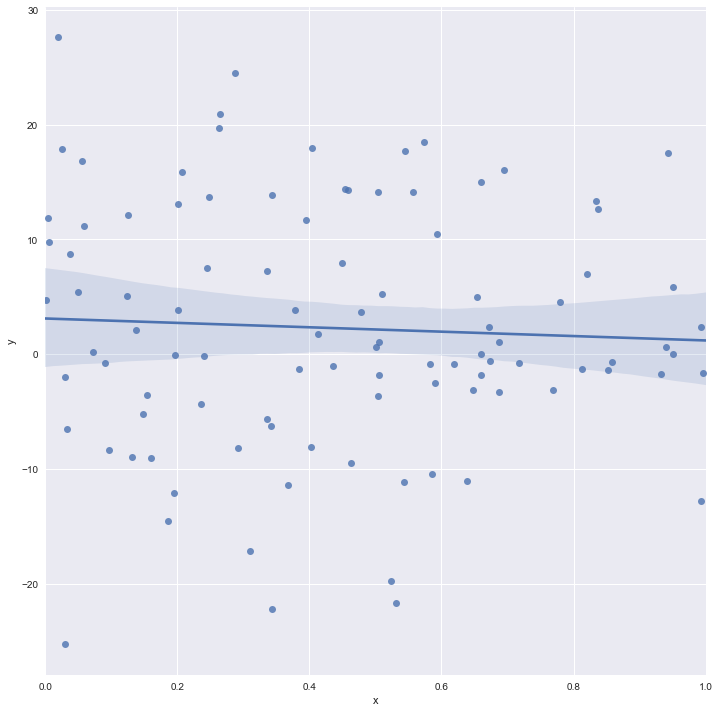

In [27]:
# These are our "true" parameters
beta_0 = 1.0  # Intercept
beta_1 = 2.0  # Slope

# Sampling parameters
N = 100
eps_mean = 0
# eps_sigma_sq = .5 # Low noise, signal can filtered out
eps_sigma_sq = 10 # High noise, signal is gone 😢

# Simulate the "linear" data using the above parameters
df = simulate_linear_data(N, beta_0, beta_1, eps_mean, eps_sigma_sq)

# Plot the data with a frequentist linear regression fit
sns.lmplot(x="x", y="y", data=df, size=10)
plt.xlim(0.0, 1.0);

In [28]:
import pymc3 as pm

In [29]:
# Use PyMC3 to construct a model context
basic_model = pm.Model()
with basic_model:

    pm.glm.glm("y ~ x", # Define glm using the R / Patsy model syntax
               df, 
               family=pm.glm.families.Normal()) # Normal distribution for the likelihood

    # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
    start = pm.find_MAP()

    # Use the No-U-Turn Sampler
    step = pm.NUTS()

    # Calculate the trace
    iterations = 5000
    trace = pm.sample(iterations, 
                    step, 
                    start, 
                    random_seed=42, 
                    progressbar=True)

Optimization terminated successfully.
         Current function value: 408.746798
         Iterations: 22


100%|██████████| 5000/5000 [00:09<00:00, 724.72it/s]

         Function evaluations: 23
         Gradient evaluations: 23


In [30]:
temp = pm.trace_to_dataframe(trace[500:])
temp.head(n=5)

,Intercept,x,sd
0,4.048312,-1.076875,10.823281
1,3.452379,-1.818980,10.469342
2,3.452379,-1.818980,10.469342
3,4.465973,-5.178132,11.251766
4,4.489349,-5.663967,9.450639


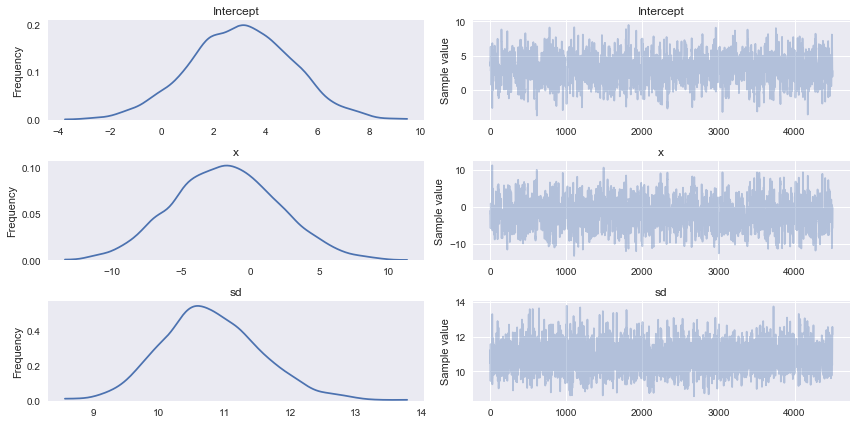

In [31]:
pm.traceplot(trace[500:]) # NOTE: Skip the 1st couple of trials for "burn-in"
plt.show()

In [32]:
df.head(1)

,x,y
0,0.24813,13.684955


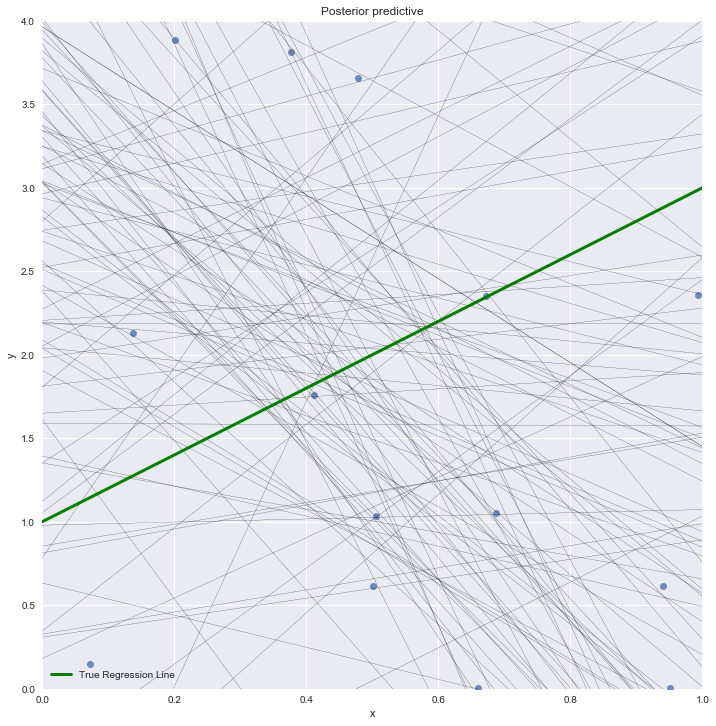

In [33]:
# Plot a sample of posterior regression lines
sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)
pm.glm.plot_posterior_predictive(trace, samples=100)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
plt.show()

<center><img src="https://cdn.meme.am/cache/instances/folder280/500x/55126280.jpg" width="500"/></center>